# CycleGAN: Converting Blond Hair to Black Hair

In [13]:
# installation
!pip install albumentations


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


# 1. CycleGAN and Cycle Consistency Loss

# 2. The celebrity faces dataset

## 2.1. Download the Celebrity Faces Dataset
You can download the celebrity faces dataset is from Kaggle. Log into Kaggle and go to the link https://www.kaggle.com/datasets/jessicali9530/celeba-dataset to download dataset. 

In [14]:
import pandas as pd
import os, shutil

df=pd.read_csv("data/CelebA/list_attr_celeba.csv")    #A
os.makedirs("files/black", exist_ok=True)  
os.makedirs("files/blond", exist_ok=True)    #B      
folder="data/CelebA/img_align_celeba/img_align_celeba"
for i in range(len(df)):
    dfi=df.iloc[i]
    if dfi['Black_Hair']==1:    #C
        try:
            oldpath=f"{folder}/{dfi['image_id']}"
            newpath=f"files/black/{dfi['image_id']}"
            shutil.move(oldpath, newpath)
        except:
            pass
    elif dfi['Blond_Hair']==1:    #D
        try:
            oldpath=f"{folder}/{dfi['image_id']}"
            newpath=f"files/blond/{dfi['image_id']}"
            shutil.move(oldpath, newpath)
        except:
            pass

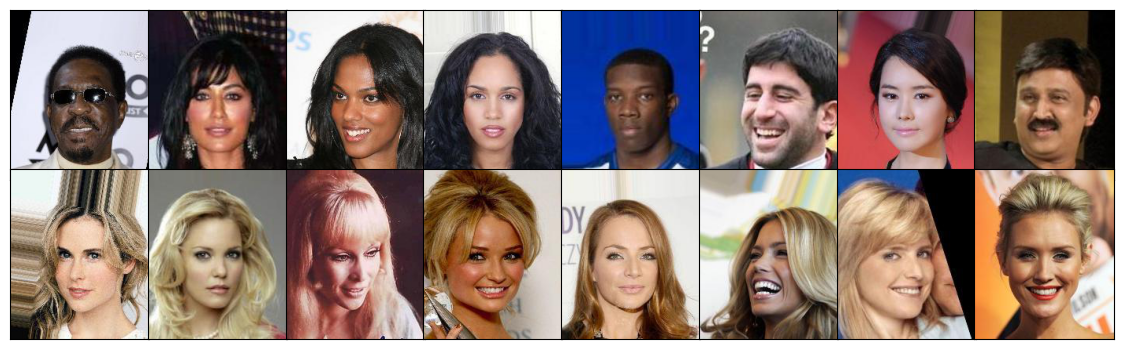

In [15]:
trainA=r"files/black/"
trainB=r"files/blond/"

import random
import matplotlib.pyplot as plt
from PIL import Image

imgs=os.listdir(trainA)
random.seed(42)
samples=random.sample(imgs,8)
imgs1=os.listdir(trainB)
random.seed(42)
samples1=random.sample(imgs1,8)
fs=[trainA,trainB]
ps=[imgs,imgs1]
fig=plt.figure(dpi=100, figsize=(1.78*8,2.18*2))
for i in range(16):
    ax = plt.subplot(2, 8, i + 1)
    folder=i//8
    p=i%8
    img=Image.open(fr"{fs[folder]}{ps[folder][p]}")
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.subplots_adjust(wspace=-0.01,hspace=-0.1)
plt.show() 

## 2.2	Process the black and blond hair image data

In [16]:

from torch.utils.data import Dataset
class LoadData(Dataset):
    def __init__(self, root_A, root_B, transform=None):
        super().__init__()
        self.root_A = root_A
        self.root_B = root_B
        self.transform = transform
        self.A_images = []
        for r in root_A:
            files=os.listdir(r)
            self.A_images += [r+i for i in files]
        self.B_images = []
        for r in root_B:
            files=os.listdir(r)
            self.B_images += [r+i for i in files]      
        self.len_data = max(len(self.A_images),
                            len(self.B_images))
        self.A_len = len(self.A_images)
        self.B_len = len(self.B_images)
    def __len__(self):
        return self.len_data
    def __getitem__(self, index):
        A_img = self.A_images[index % self.A_len]
        B_img = self.B_images[index % self.B_len]
        A_img = np.array(Image.open(A_img).convert("RGB"))
        B_img = np.array(Image.open(B_img).convert("RGB"))
        if self.transform:
            augmentations = self.transform(image=B_img,
                                           image0=A_img)
            B_img = augmentations["image"]
            A_img = augmentations["image0"]
        return A_img, B_img 

In [17]:

from torch.utils.data import DataLoader
from tqdm import tqdm
import albumentations 
from albumentations.pytorch import ToTensorV2

transforms = albumentations.Compose(
    [albumentations.Resize(width=256, height=256),    #A
        albumentations.HorizontalFlip(p=0.5),
        albumentations.Normalize(mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5],max_pixel_value=255),    #B
        ToTensorV2()],
    additional_targets={"image0": "image"}) 
dataset = LoadData(root_A=["files/black/"],
    root_B=["files/blond/"],
    transform=transforms)    #C
loader=DataLoader(dataset,batch_size=1,
    shuffle=True, pin_memory=True)    #D

# 3. Build a CycleGAN model
## 3.1	Create two discriminators

In [ ]:

import numpy as np
import os
import torch
import numpy as np
import torch.nn as nn
from PIL import Image
from torch.utils.data import Dataset
from tqdm import tqdm
from torchvision.utils import save_image


def train_epoch(disc_A, disc_B, gen_A, gen_B, loader, opt_disc,
        opt_gen, l1, mse, d_scaler, g_scaler,device):
    loop = tqdm(loader, leave=True)

    for i, (A,B) in enumerate(loop):
        A=A.to(device)
        B=B.to(device)

        # Train Discriminators A and B
        with torch.amp.autocast("cuda"):
            fake_A = gen_A(B)
            D_A_real = disc_A(A)
            D_A_fake = disc_A(fake_A.detach())
            D_A_real_loss = mse(D_A_real, torch.ones_like(D_A_real))
            D_A_fake_loss = mse(D_A_fake, torch.zeros_like(D_A_fake))
            D_A_loss = D_A_real_loss + D_A_fake_loss

            fake_B = gen_B(A)
            D_B_real = disc_B(B)
            D_B_fake = disc_B(fake_B.detach())
            D_B_real_loss = mse(D_B_real, torch.ones_like(D_B_real))
            D_B_fake_loss = mse(D_B_fake, torch.zeros_like(D_B_fake))
            D_B_loss = D_B_real_loss + D_B_fake_loss

            # Average loss of the two discriminators
            D_loss = (D_A_loss + D_B_loss) / 2

        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()
        # Train the two generators 
        with torch.amp.autocast("cuda"):
            D_A_fake = disc_A(fake_A)
            D_B_fake = disc_B(fake_B)
            loss_G_A = mse(D_A_fake, torch.ones_like(D_A_fake))
            loss_G_B = mse(D_B_fake, torch.ones_like(D_B_fake))
            # NEW in Cycle GANs: cycle loss
            cycle_B = gen_B(fake_A)
            cycle_A = gen_A(fake_B)
            cycle_B_loss = l1(B, cycle_B)
            cycle_A_loss = l1(A, cycle_A)
            # Total generator loss
            G_loss=(loss_G_A+loss_G_B+cycle_A_loss*10
                +cycle_B_loss*10)
        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()
        if i % 100 == 0:
            test(i,A,B,fake_A,fake_B)            
        loop.set_postfix(D_loss=D_loss.item(),G_loss=G_loss.item())

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, 
                 down=True, use_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 
                      padding_mode="reflect", **kwargs)
            if down
            else nn.ConvTranspose2d(in_channels, 
                                    out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity())
    def forward(self, x):
        return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels,channels,kernel_size=3,padding=1),
            ConvBlock(channels,channels,
                      use_act=False, kernel_size=3, padding=1))
    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, img_channels, num_features=64,
                 num_residuals=9):
        super().__init__()     
        self.initial = nn.Sequential(
            nn.Conv2d(img_channels,num_features,kernel_size=7,
                stride=1,padding=3,padding_mode="reflect",),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True))
        self.down_blocks = nn.ModuleList(
            [ConvBlock(num_features,num_features*2,kernel_size=3,
                       stride=2, padding=1),
            ConvBlock(num_features*2,num_features*4,kernel_size=3,
                stride=2,padding=1)])
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(num_features * 4) 
            for _ in range(num_residuals)])
        self.up_blocks = nn.ModuleList(
            [ConvBlock(num_features * 4, num_features * 2,
                    down=False, kernel_size=3, stride=2,
                    padding=1, output_padding=1),
                ConvBlock(num_features * 2, num_features * 1,
                    down=False,kernel_size=3, stride=2,
                    padding=1, output_padding=1)])
        self.last = nn.Conv2d(num_features * 1, img_channels,
            kernel_size=7, stride=1,
            padding=3, padding_mode="reflect")
        
    def forward(self, x):
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        x = self.res_blocks(x)
        for layer in self.up_blocks:
            x = layer(x)
        return torch.tanh(self.last(x))
    
    
    

class Block(nn.Module):
    def __init__(self,in_channels,out_channels,stride):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,4,stride,1,
                padding_mode="reflect"),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2,inplace=True))
    def forward(self, x):
        return self.conv(x)

class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64,128,256,512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels,features[0],
                kernel_size=4,stride=2,padding=1,
                padding_mode="reflect"),
            nn.LeakyReLU(0.2, inplace=True))
        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(Block(in_channels, feature, 
                stride=1 if feature == features[-1] else 2))
            in_channels = feature
        layers.append(nn.Conv2d(in_channels,1,kernel_size=4,
                stride=1,padding=1,padding_mode="reflect"))
        self.model = nn.Sequential(*layers)
    def forward(self, x):
        out = self.model(self.initial(x))
        return torch.sigmoid(out)    



def weights_init(m):
    name = m.__class__.__name__
    if name.find('Conv') != -1 or name.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif name.find('Norm2d') != -1:
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)             

In [19]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
disc_A = Discriminator().to(device)
disc_B = Discriminator().to(device)    #B
weights_init(disc_A)
weights_init(disc_B)    #C

## 3.2	Create two generators

In [20]:

gen_A = Generator(img_channels=3, num_residuals=9).to(device)
gen_B = Generator(img_channels=3, num_residuals=9).to(device)
weights_init(gen_A)
weights_init(gen_B)

In [21]:
import torch.nn as nn

l1 = nn.L1Loss()
mse = nn.MSELoss()
g_scaler = torch.amp.GradScaler("cuda")
d_scaler = torch.amp.GradScaler("cuda")

/tmp/ipykernel_24532/1978380629.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  g_scaler = torch.cuda.amp.GradScaler()
/tmp/ipykernel_24532/1978380629.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  d_scaler = torch.cuda.amp.GradScaler()


In [22]:
lr = 0.00001
opt_disc = torch.optim.Adam(list(disc_A.parameters()) + 
  list(disc_B.parameters()),lr=lr,betas=(0.5, 0.999))
opt_gen = torch.optim.Adam(list(gen_A.parameters()) + 
  list(gen_B.parameters()),lr=lr,betas=(0.5, 0.999))

# 4. CycleGAN to translate between black and blond hair
## 4.1	Train a CycleGAN to translate between black and blond hair

In [23]:
def test(i,A,B,fake_A,fake_B):
    save_image(A*0.5+0.5,f"files/A{i}.png")
    save_image(B*0.5+0.5,f"files/B{i}.png")    #A
    save_image(fake_A*0.5+0.5,f"files/fakeA{i}.png")
    save_image(fake_B*0.5+0.5,f"files/fakeB{i}.png")    #B

In [24]:

for epoch in range(1):
    train_epoch(disc_A, disc_B, gen_A, gen_B, loader, opt_disc,
    opt_gen, l1, mse, d_scaler, g_scaler, device)    #A
torch.save(gen_A.state_dict(), "files/gen_black.pth")
torch.save(gen_B.state_dict(), "files/gen_blond.pth")    #B

100%|██████████| 48472/48472 [1:00:02<00:00, 13.45it/s, D_loss=0.557, G_loss=2.35]


Download the pretrained model from my website https://gattonweb.uky.edu/faculty/lium/ml/hair.zip 

In [25]:
# answer to exercise 6.1
dataset = LoadData(root_A=["files/blond/"],
    root_B=["files/black/"],
    transform=transforms)    

## 4.2. Roundtrip conversions of black hair images and blond hair images

In [26]:
from torchvision.utils import save_image

gen_A.load_state_dict(torch.load("files/gen_black.pth"))
gen_B.load_state_dict(torch.load("files/gen_blond.pth"))
i=1
for black,blond in loader:
    fake_blond=gen_B(black.to(device))
    save_image(black*0.5+0.5,f"files/black{i}.png")
    save_image(fake_blond*0.5+0.5,f"files/fakeblond{i}.png")   
    fake2black=gen_A(fake_blond)
    save_image(fake2black*0.5+0.5,f"files/fake2black{i}.png")    
    fake_black=gen_A(blond.to(device))
    save_image(blond*0.5+0.5,f"files/blond{i}.png")
    save_image(fake_black*0.5+0.5,f"files/fakeblack{i}.png")
    fake2blond=gen_B(fake_black)
    save_image(fake2blond*0.5+0.5,f"files/fake2blond{i}.png")  
    i=i+1
    if i>10:
        break

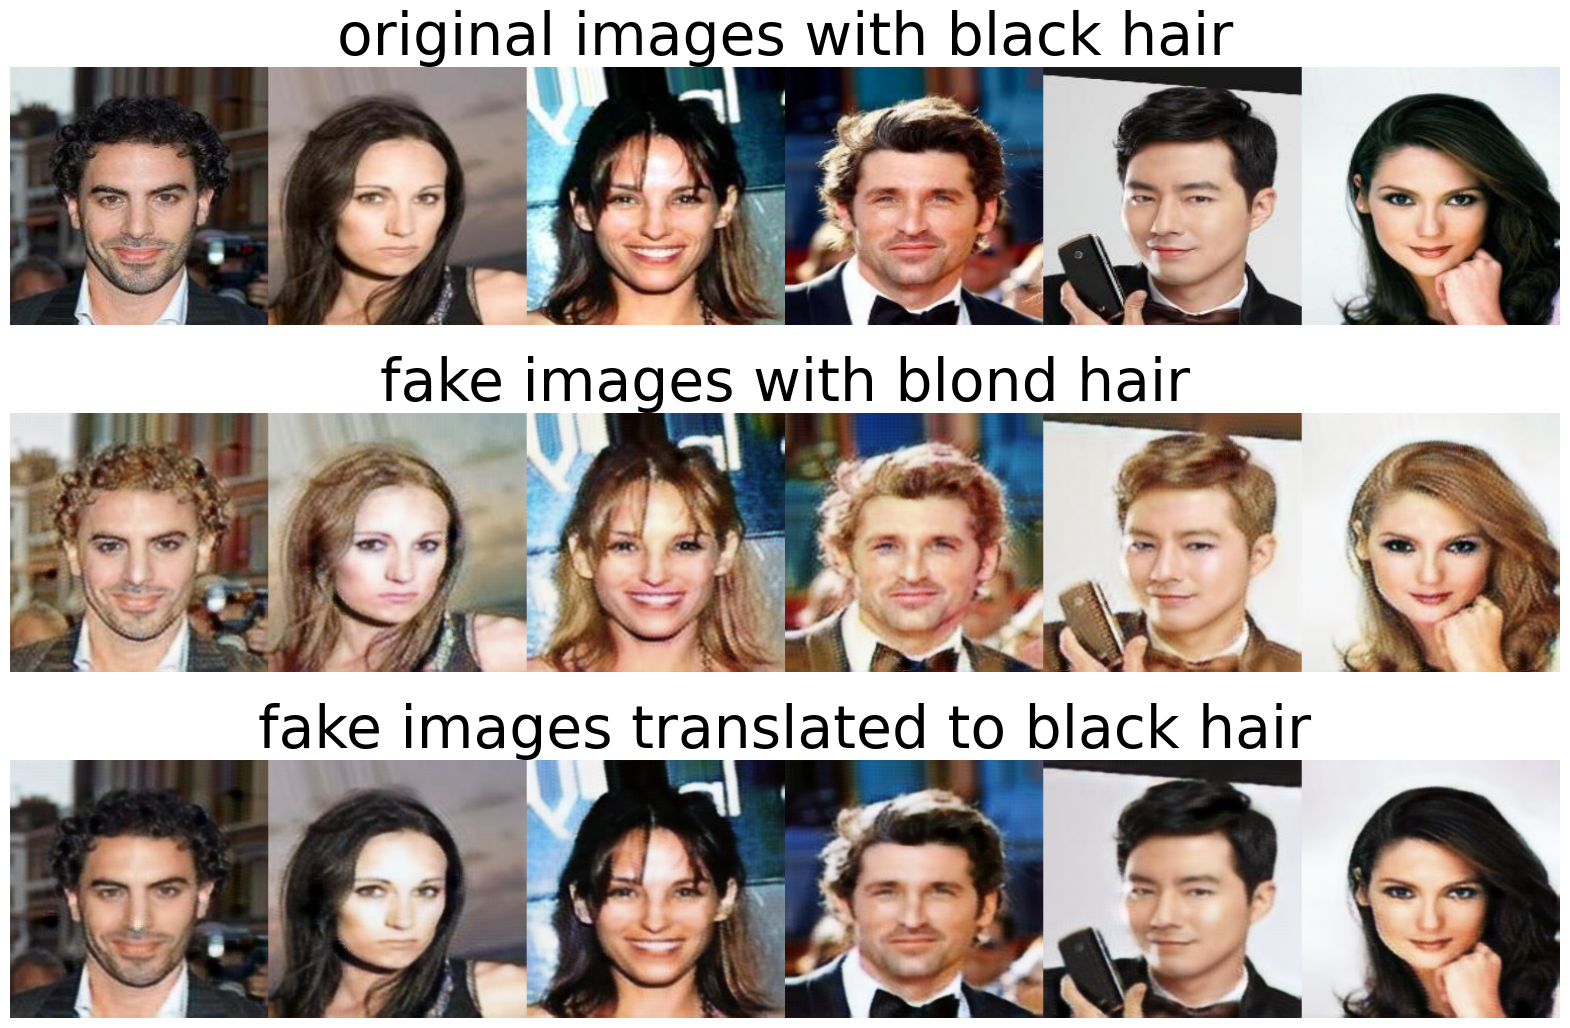




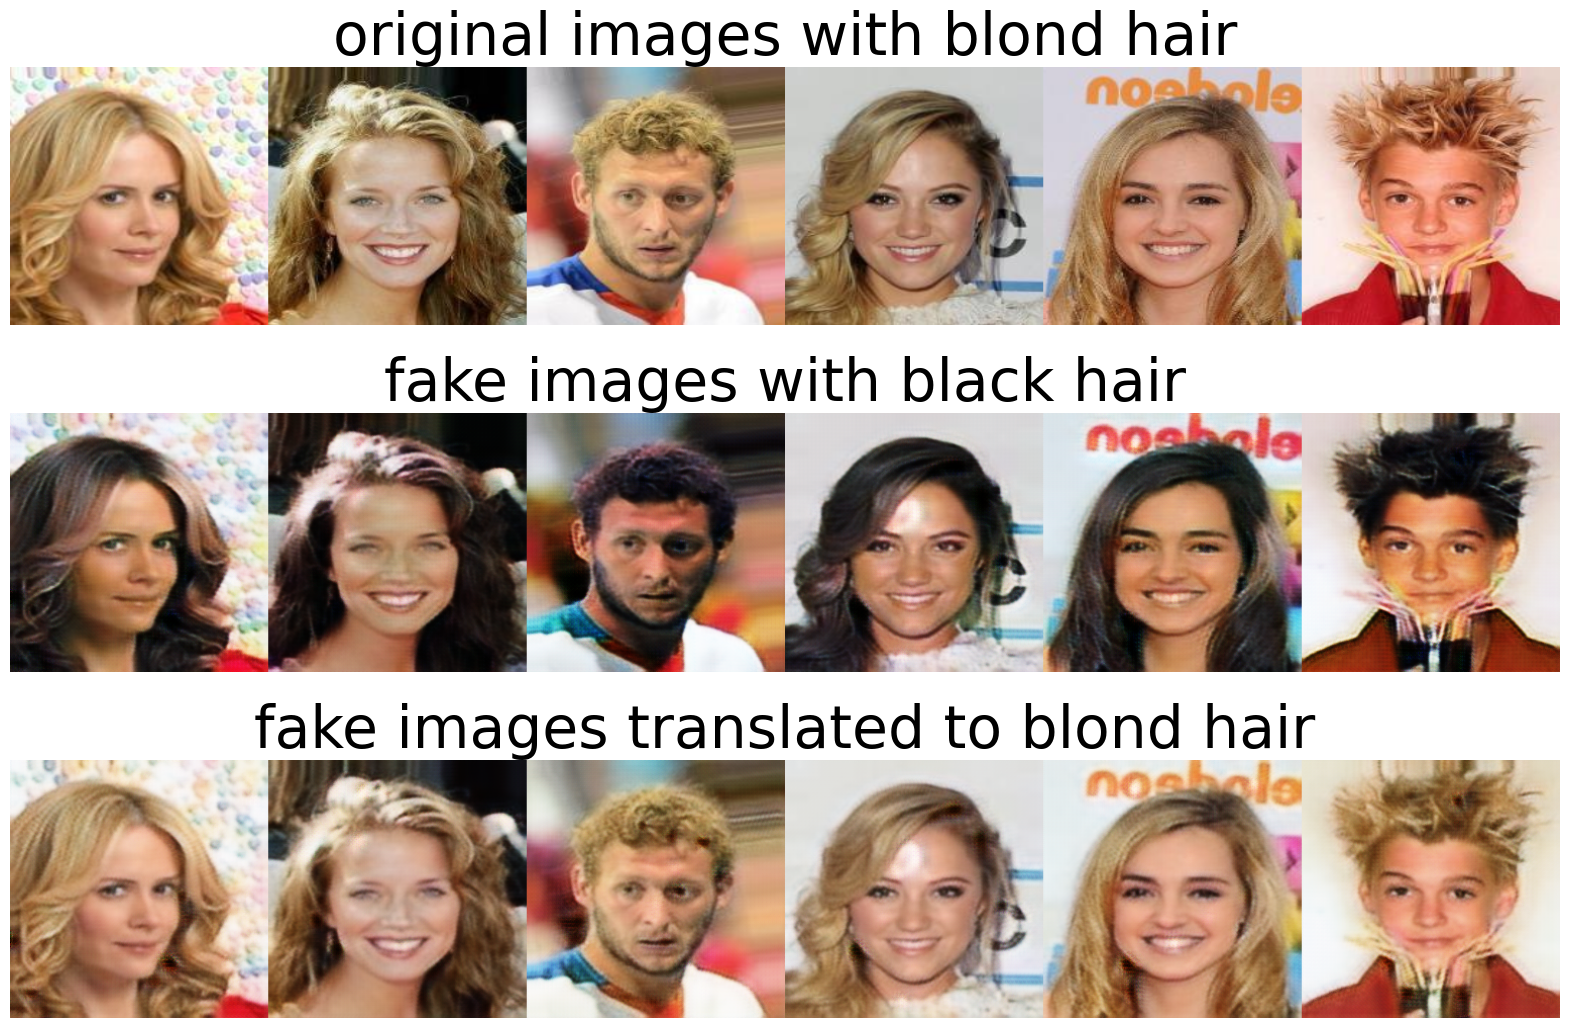

In [ ]:
# solution to exercise 6.2

disc_A = Discriminator().to(device)
disc_B = Discriminator().to(device)
gen_A = Generator(img_channels=3, num_residuals=9).to(device)
gen_B = Generator(img_channels=3, num_residuals=9).to(device)
weights_init(gen_A)
weights_init(disc_A)
weights_init(gen_B)
weights_init(disc_B)
opt_disc = torch.optim.Adam(list(disc_A.parameters()) + 
  list(disc_B.parameters()),lr=lr,betas=(0.5, 0.999))
opt_gen = torch.optim.Adam(list(gen_A.parameters()) + 
  list(gen_B.parameters()),lr=lr,betas=(0.5, 0.999))

# make sure all images with glasses are placed in 'files/glasses/G/'
# all images without glasses are placed in 'files/glasses/NoG/'
# Manually move images to the correct folder if they are mislabelled
dataset = LoadData(root_A=['files/glasses/G/'],
    root_B=['files/glasses/NoG/'],
    transform=transforms)
loader=DataLoader(dataset,batch_size=1,
    shuffle=True, pin_memory=True)
for epoch in range(1):
    train_epoch(disc_A, disc_B, gen_A, gen_B, loader, opt_disc,
    opt_gen, l1, mse, d_scaler, g_scaler, device)
torch.save(gen_A.state_dict(), "files/add_glasses.pth")
torch.save(gen_B.state_dict(), "files/remove_glasses.pth")


100%|██████████| 2856/2856 [05:25<00:00,  8.78it/s, D_loss=0.389, G_loss=2.27]


How the trained model removes glasses: the left image in each pair are the original image with glasses; the image on the right is the one after the trained model removed the glasses from the image
<img src="https://gattonweb.uky.edu/faculty/lium/ml/removeglasses.jpg" />   

How the trained model adds glasses: the left image in each pair are the original image without glasses; the image on the right is the one after the trained model added glasses to the image
<img src="https://gattonweb.uky.edu/faculty/lium/ml/addglasses.jpg" />   